In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blink
from pathlib import Path
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import os


In [ ]:
#Synchronisation et chargement des fichiers
BASE_LSL = Path(r"C:/Users/yuz/Documents/Test_LOOK/data_lsl/data_exacted")
BASE_TOBII = Path(r"C:/Users/yuz/Documents/Test_LOOK/data_Tobii/data_exacted")

def extract_segments(participant, task):
    psychopy_path = BASE_LSL / participant / f"{participant}_{task.lower()}_psychopy.csv"
    psychopy_df = pd.read_csv(psychopy_path, sep=";", header=None, names=["label", "time"])
    segments = {}
    current_segment = None
    for _, row in psychopy_df.iterrows():
        if pd.isna(row["label"]) or row["label"].strip() == "":
            continue
        label = row["label"].strip()
        time = row["time"]
        if label.lower().endswith("_start"):
            current_segment = label[:-6]  # Remove '_start'
            segments[current_segment] = {"start": time, "end": None}
        elif label.lower().endswith("_end"):
            current_segment = label[:-4]  # Remove '_end'
            if current_segment in segments:
                segments[current_segment]["end"] = time
    segments = {k: v for k, v in segments.items() if v["start"] is not None and v["end"] is not None}
    return segments


In [ ]:
# ==== USER PARAMETERS ====
PARTICIPANT = "05_EB"
TASK = "MBI_conversation_2"
PSYCHOPY_TASK = "conversation"
EYE = "right"
# =========================

In [ ]:
# Get segment times
segments = extract_segments(PARTICIPANT, PSYCHOPY_TASK)
start_time, end_time = segments[TASK]["start"], segments[TASK]["end"]

# EOG Data (1000 Hz)
eog_file = BASE_LSL / PARTICIPANT / f"{PARTICIPANT}_{PSYCHOPY_TASK.lower()}_EOG.csv"
df_eog = pd.read_csv(eog_file, sep=";", names=["EOG", "time"])
df_eog_segment = df_eog[(df_eog["time"] >= start_time) & (df_eog["time"] <= end_time)]
eog_signal = df_eog_segment["EOG"].to_numpy()
eog_time = np.arange(len(eog_signal)) / 1000 

# Tobii Data (1200 Hz)
tobii_file = BASE_TOBII / PARTICIPANT / f"{PARTICIPANT}_{TASK}.tsv"
df_tobii = pd.read_csv(tobii_file, sep="\t")
eye_openness_signal = df_tobii[f"{EYE}_eye_openness_diameter"].to_numpy()
eye_time = np.arange(len(eye_openness_signal)) / 1200 

# Blink Detection proposed by Tobii
settings = blink.Settings()
settings.Fs = 1200
bd = blink.BlinkDetector(settings)

df_eo, _ = bd.blink_detector_eo(eye_time, eye_openness_signal, settings.Fs,
                                filter_length=settings.filter_length,
                                gap_dur=settings.gap_dur,
                                width_of_blink=settings.width_of_blink,
                                min_separation=settings.min_separation)

blink_peaks_time = df_eo["time_peak"].to_numpy()
peak_idx = np.searchsorted(eye_time, blink_peaks_time)

c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


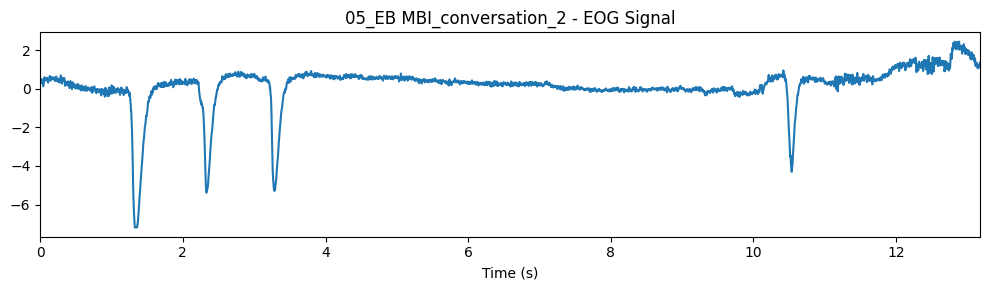

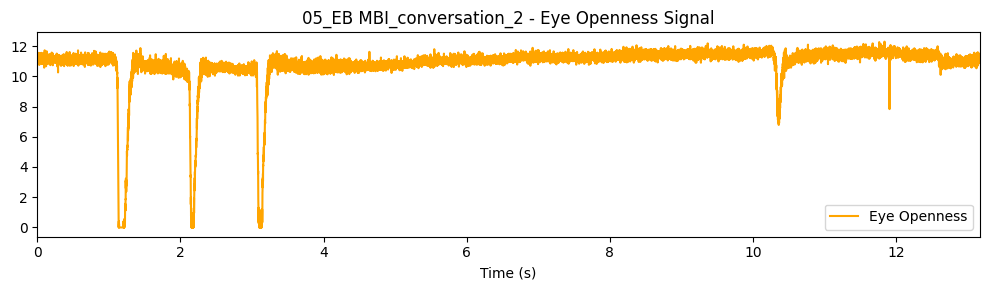

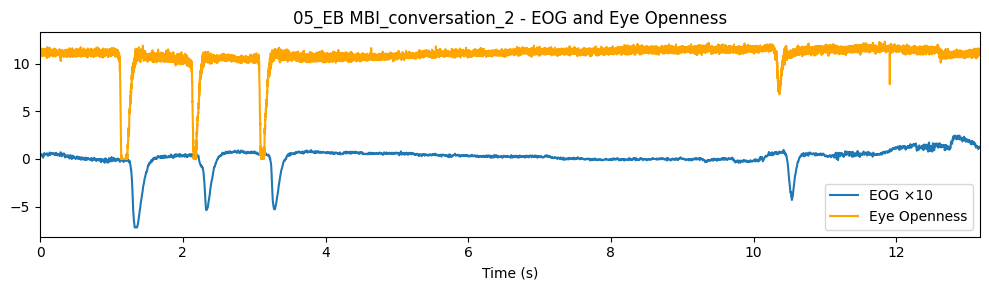

In [85]:
# Plot EOG
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal * 10, label="EOG ×10", color="tab:blue")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - EOG Signal")
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

# Plot Eye Openness
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal, label="Eye Openness", color="orange")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Eye Openness Signal")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

# Plot Both Together
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal * 10, label="EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal, label="Eye Openness", color="orange")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - EOG and Eye Openness")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), min(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()


In [ ]:
#FFT
# --- FFT for EOG signal ---
fs_eog = 1000 
N_eog = len(eog_signal)
yf_eog = np.abs(rfft(eog_signal - np.mean(eog_signal)))
xf_eog = rfftfreq(N_eog, 1 / fs_eog)

# --- FFT for Eye Openness signal ---
fs_openness = 1200
N_open = len(eye_openness_signal)
yf_open = np.abs(rfft(eye_openness_signal - np.mean(eye_openness_signal)))
xf_open = rfftfreq(N_open, 1 / fs_openness)

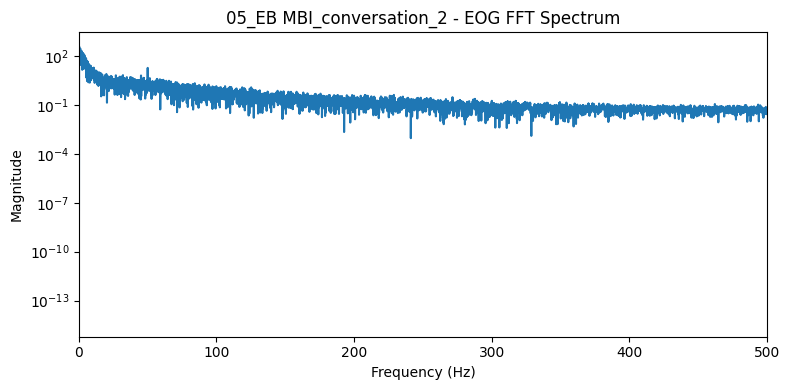

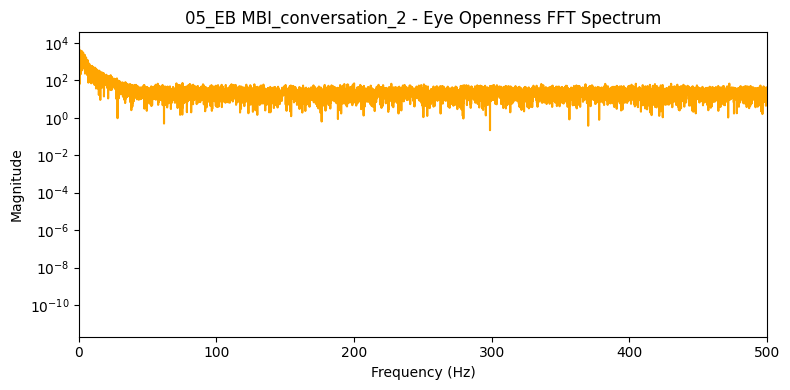

In [ ]:
#plot the FFT 
plt.figure(figsize=(8, 4))
plt.semilogy(xf_eog, yf_eog, label='EOG')
plt.title(f"{PARTICIPANT} {TASK} - EOG FFT Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 500)  
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.semilogy(xf_open, yf_open, color='orange', label='Eye Openness')
plt.title(f"{PARTICIPANT} {TASK} - Eye Openness FFT Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

In [ ]:
#Apply filter via FFT result, threshold to be adjust
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)
def lowpass_filter(data, fs, cutoff, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply lowpass filter: 
eog_signal_filt = lowpass_filter(eog_signal, fs=1000, cutoff=5)
eye_openness_signal_filt = lowpass_filter(eye_openness_signal, fs=1200, cutoff=5)



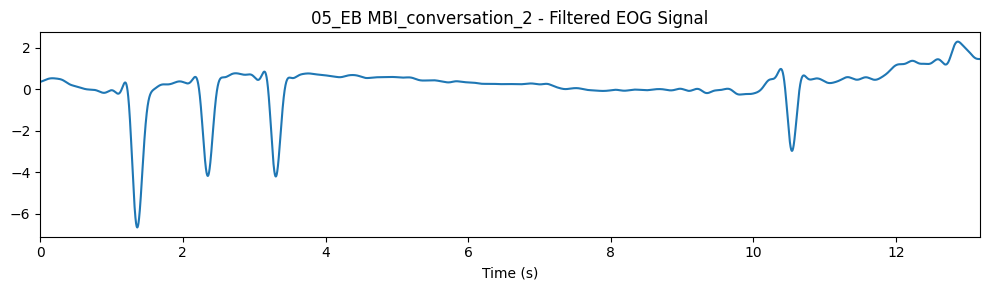

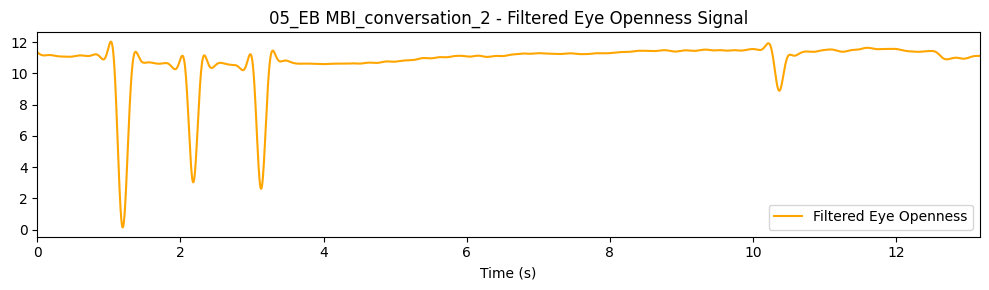

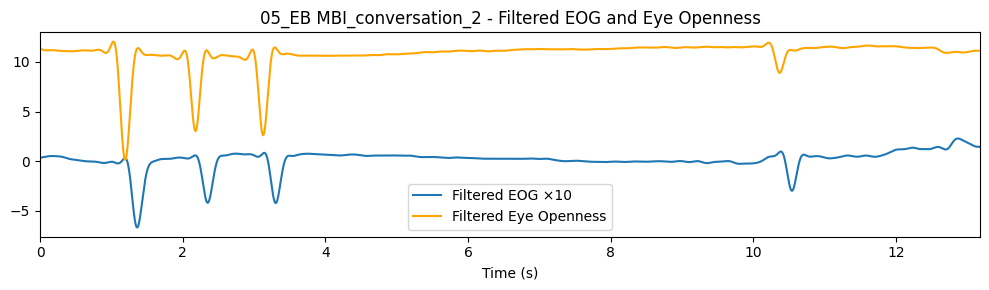

In [ ]:
# Plot Filtered EOG
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG Signal")
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

# Plot Filtered Eye Openness
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
if len(blink_peaks_time) > 0:
    blink_peaks_y_filt = np.interp(blink_peaks_time, eye_time, eye_openness_signal_filt)
    plt.plot(blink_peaks_time, blink_peaks_y_filt, "kx", ms=10, lw=2, label="Blink peaks")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered Eye Openness Signal")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

# Plot Both Filtered Signals Together
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
if len(blink_peaks_time) > 0:
    plt.plot(blink_peaks_time, blink_peaks_y_filt, "kx", ms=10, lw=2, label="Blink peaks")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG and Eye Openness")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), max(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()

In [ ]:
# ----- Adjustable blink detection parameters -----
# Eye Openness: threshold and width
max_blink_amplitude_openness = 10
min_blink_width_ms_openness = 10
max_blink_width_ms_openness = 550  
prominence_openness=0.01

# EOG: threshold and width RANGE
min_blink_amplitude_eog = 0.1      
min_blink_width_ms_eog = 10          
max_blink_width_ms_eog = 1500      
prominence_eog = 0.1         
 

EOG_POLARITY = 'negative'

width_samples_openness = int(np.round(min_blink_width_ms_openness / 1000 * 1200))
openness_thresh = max_blink_amplitude_openness
min_width_samples_eog = int(np.round(min_blink_width_ms_eog / 1000 * 1000))
max_width_samples_eog = int(np.round(max_blink_width_ms_eog / 1000 * 1000))


In [ ]:
# --- Find blinks in filtered Eye Openness ---
peaks_openness, props_open = find_peaks(
    -eye_openness_signal_filt,
    height=-openness_thresh,
    distance=width_samples_openness,
    width=(min_blink_width_ms_openness, max_blink_width_ms_openness),
    prominence=prominence_openness
)
blink_peaks_time_openness = eye_time[peaks_openness]
blink_peaks_y_openness = eye_openness_signal_filt[peaks_openness]

print("=== Eye Openness Blinks (filtered) ===")
for i, idx in enumerate(peaks_openness):
    print(f"Blink {i+1}: Sample {idx}, Time {eye_time[idx]:.3f}s, Openness {eye_openness_signal_filt[idx]:.2f} mm")

# --- Find blinks in filtered EOG ---
if EOG_POLARITY == 'negative':
    eog_for_peaks = -eog_signal_filt
    height_eog = abs(min_blink_amplitude_eog)
else:
    eog_for_peaks = eog_signal_filt
    height_eog = min_blink_amplitude_eog


peaks_eog, props_eog = find_peaks(
    eog_for_peaks,
    height=height_eog,
    distance=min_width_samples_eog,
    width=(min_width_samples_eog, max_width_samples_eog),
    prominence=prominence_eog   
)
blink_peaks_time_eog = eog_time[peaks_eog]
blink_peaks_y_eog = eog_signal_filt[peaks_eog]

print("=== EOG Blinks (filtered) ===")
for i, idx in enumerate(peaks_eog):
    print(f"Blink {i+1}: Sample {idx}, Time {eog_time[idx]:.3f}s, EOG {eog_signal_filt[idx]:.2f}")

# --- Calculate difference for each filtered EOG blink to nearest filtered Eye Openness blink ---
blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(blink_peaks_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - blink_peaks_time_openness[np.argmin(np.abs(blink_peaks_time_openness - t_eog))]
    blink_time_diffs.append(diff)

blink_time_diffs_np=np.array(blink_time_diffs)

# Define a Gaussian weight: higher for values near 0
sigma = 0.1  # adjust sigma as needed; 0.1 gives more weight to values close to 0
weights = np.exp(-0.5 * (blink_time_diffs_np / sigma) ** 2)


# Weighted average |delta t|
if np.sum(weights) > 0:
    avg_delta_t_weighted = np.sum(np.abs(blink_time_diffs_np) * weights) / np.sum(weights)
else:
    avg_delta_t_weighted = np.nan


    
    # --- Apply translation (e.g., shift EyeOpenness blinks by +0.08s) ---
translation_value = avg_delta_t_weighted

print("=== Blink time difference (EOG - EyeOpenness, filtered) for each EOG blink [s] ===")
for i, diff in enumerate(blink_time_diffs):
    print(f"EOG blink {i+1} at {blink_peaks_time_eog[i]:.3f}s, closest Eye Openness blink: Δt = {diff:.4f} s")
print("Gaussian average translation: ", translation_value)

=== Eye Openness Blinks (filtered) ===
Blink 1: Sample 1432, Time 1.193s, Openness 0.14 mm
Blink 2: Sample 2614, Time 2.178s, Openness 3.03 mm
Blink 3: Sample 3752, Time 3.127s, Openness 2.61 mm
Blink 4: Sample 12441, Time 10.367s, Openness 8.88 mm
=== EOG Blinks (filtered) ===
Blink 1: Sample 1361, Time 1.361s, EOG -0.67
Blink 2: Sample 2349, Time 2.349s, EOG -0.42
Blink 3: Sample 3303, Time 3.303s, EOG -0.42
Blink 4: Sample 10541, Time 10.541s, EOG -0.30
=== Blink time difference (EOG - EyeOpenness, filtered) for each EOG blink [s] ===
EOG blink 1 at 1.361s, closest Eye Openness blink: Δt = 0.1677 s
EOG blink 2 at 2.349s, closest Eye Openness blink: Δt = 0.1707 s
EOG blink 3 at 3.303s, closest Eye Openness blink: Δt = 0.1763 s
EOG blink 4 at 10.541s, closest Eye Openness blink: Δt = 0.1735 s
Gaussian average translation:  0.17186292631793812


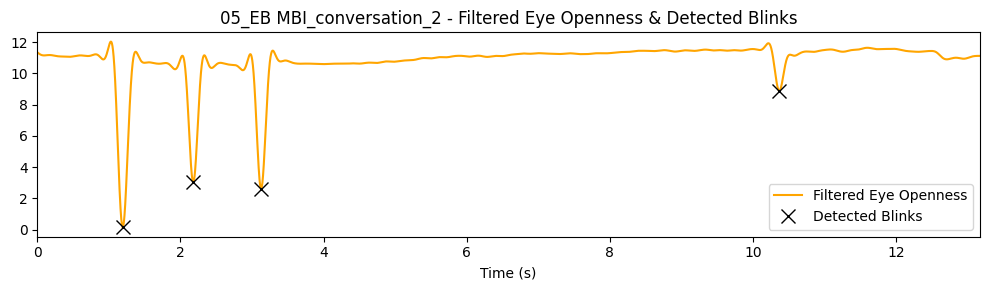

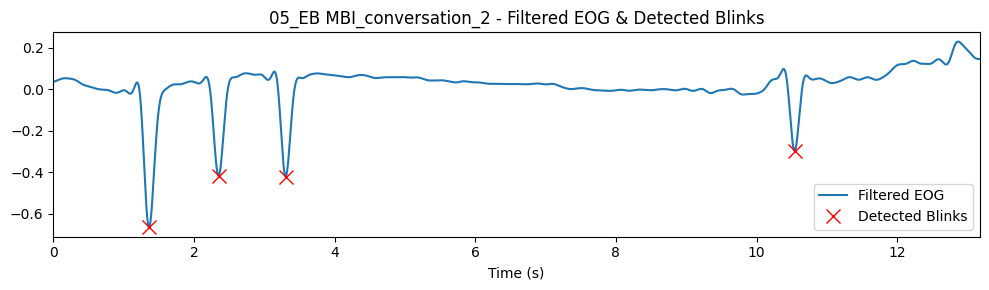

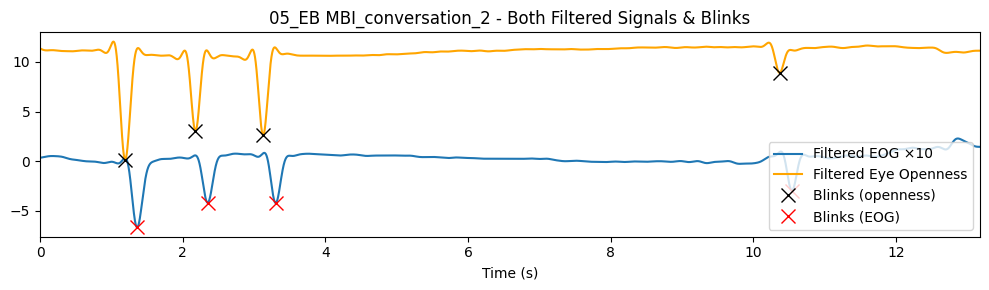

In [ ]:
#plot with filtered data and blink detection 
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peaks_time_openness, blink_peaks_y_openness, "kx", ms=10, lw=2, label="Detected Blinks")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered Eye Openness & Detected Blinks")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt, label="Filtered EOG", color="tab:blue")
plt.plot(blink_peaks_time_eog, blink_peaks_y_eog, "rx", ms=10, lw=2, label="Detected Blinks")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG & Detected Blinks")
plt.legend()
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peaks_time_openness, blink_peaks_y_openness, "kx", ms=10, lw=2, label="Blinks (openness)")
plt.plot(blink_peaks_time_eog, blink_peaks_y_eog * 10, "rx", ms=10, lw=2, label="Blinks (EOG)")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Both Filtered Signals & Blinks")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), max(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()

In [ ]:
# --- Calculate difference for each filtered EOG blink to nearest filtered Eye Openness blink ---
# --- Apply translation ---
translated_blink_peaks_time_openness = blink_peaks_time_openness + translation_value

blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(blink_peaks_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - blink_peaks_time_openness[np.argmin(np.abs(blink_peaks_time_openness - t_eog))]
    blink_time_diffs.append(diff)

print("=== Blink time difference (EOG - EyeOpenness, filtered) for each EOG blink [s] ===")
for i, diff in enumerate(blink_time_diffs):
    print(f"EOG blink {i+1} at {blink_peaks_time_eog[i]:.3f}s, closest EyeOpenness blink: Δt = {diff:.4f} s")

# --- Recalculate difference for each EOG blink (filtered, translated openness) ---
translated_blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(translated_blink_peaks_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - translated_blink_peaks_time_openness[np.argmin(np.abs(translated_blink_peaks_time_openness - t_eog))]
    translated_blink_time_diffs.append(diff)

print(f"=== After translating EyeOpenness blinks (filtered) by {translation_value:.3f}s ===")
for i, diff in enumerate(translated_blink_time_diffs):
    print(f"EOG blink {i+1} at {blink_peaks_time_eog[i]:.3f}s, closest translated EyeOpenness blink: Δt = {diff:.4f} s")
print("All translated differences (s):")
for i, diff in enumerate(translated_blink_time_diffs):
    print(f"  {i+1}: {diff:.6f} s")


=== Blink time difference (EOG - EyeOpenness, filtered) for each EOG blink [s] ===
EOG blink 1 at 1.361s, closest EyeOpenness blink: Δt = 0.1677 s
EOG blink 2 at 2.349s, closest EyeOpenness blink: Δt = 0.1707 s
EOG blink 3 at 3.303s, closest EyeOpenness blink: Δt = 0.1763 s
EOG blink 4 at 10.541s, closest EyeOpenness blink: Δt = 0.1735 s
=== After translating EyeOpenness blinks (filtered) by 0.172s ===
EOG blink 1 at 1.361s, closest translated EyeOpenness blink: Δt = -0.0042 s
EOG blink 2 at 2.349s, closest translated EyeOpenness blink: Δt = -0.0012 s
EOG blink 3 at 3.303s, closest translated EyeOpenness blink: Δt = 0.0045 s
EOG blink 4 at 10.541s, closest translated EyeOpenness blink: Δt = 0.0016 s
All translated differences (s):
  1: -0.004196 s
  2: -0.001196 s
  3: 0.004470 s
  4: 0.001637 s


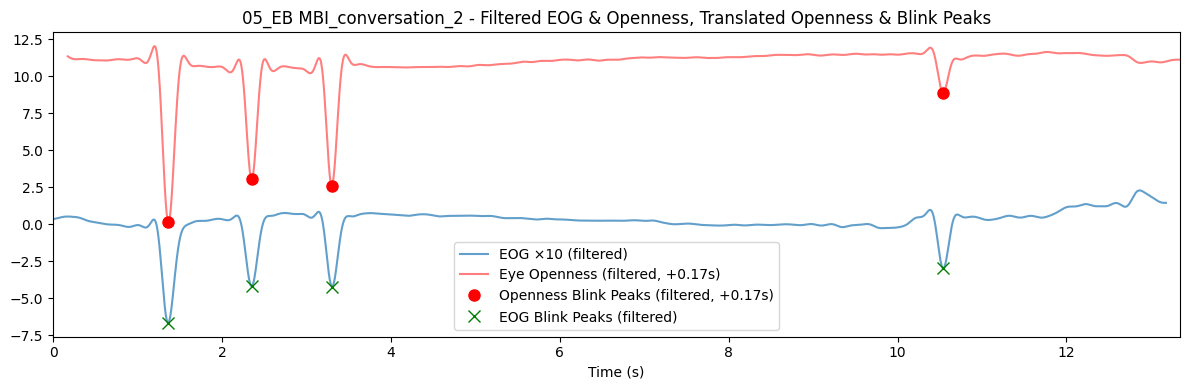

In [105]:


# Translated filtered Eye Openness signal
eye_time_translated = eye_time + translation_value

# Translated filtered Eye Openness blink peaks
translated_blink_peaks_time_openness = blink_peaks_time_openness + translation_value
y_translated_blinks = np.interp(translated_blink_peaks_time_openness, eye_time_translated, eye_openness_signal_filt)

plt.figure(figsize=(12, 4))

# Filtered signals
plt.plot(eog_time, eog_signal_filt * 10, label="EOG ×10 (filtered)", color="tab:blue", alpha=0.7)
plt.plot(eye_time_translated, eye_openness_signal_filt, label=f"Eye Openness (filtered, +{translation_value:.2f}s)", color="red", alpha=0.5)

# Translated filtered Eye Openness blink peaks
if len(translated_blink_peaks_time_openness) > 0:
    plt.plot(
        translated_blink_peaks_time_openness,
        y_translated_blinks,
        "ro", ms=8, label=f"Openness Blink Peaks (filtered, +{translation_value:.2f}s)"
    )

# Filtered EOG blink peaks
if len(blink_peaks_time_eog) > 0:
    plt.plot(
        blink_peaks_time_eog,
        blink_peaks_y_eog * 10,
        "gx", ms=9, label="EOG Blink Peaks (filtered)"
    )

plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG & Openness, Translated Openness & Blink Peaks")
plt.legend()
plt.xlim(
    min(eog_time.min(), eye_time.min(), eye_time_translated.min()), 
    max(eog_time.max(), eye_time.max(), eye_time_translated.max())
)
plt.tight_layout()
plt.show()


In [ ]:
#Save into Excel
summary_file = Path(r"C:/Users/yuz/Documents/Test_LOOK/blink_MBI_analysis_summary.xlsx")


task_id = f"{PARTICIPANT}_{TASK}"

blink_time_diffs_str = ', '.join([f"{d:.4f}" for d in blink_time_diffs])
translated_blink_time_diffs_str = ', '.join([f"{d:.4f}" for d in translated_blink_time_diffs])

MBI_eog = max(np.diff(blink_peaks_time_eog)) if len(blink_peaks_time_eog) > 1 else np.nan
MBI_tobii = max(np.diff(blink_peaks_time_openness)) if len(blink_peaks_time_openness) > 1 else np.nan

count_eog = len(blink_peaks_time_eog)
count_tobii = len(blink_peaks_time_openness)

# MBI decision rules
if np.isnan(MBI_eog) and not np.isnan(MBI_tobii):
    MBI_final = MBI_tobii
    MBI_source = "Tobii (EOG missing)"
elif np.isnan(MBI_tobii) and not np.isnan(MBI_eog):
    MBI_final = MBI_eog
    MBI_source = "EOG (Tobii missing)"
elif not np.isnan(MBI_eog) and not np.isnan(MBI_tobii):
    # Both exist
    if (MBI_eog < 1 and MBI_tobii >= 1):
        MBI_final = MBI_tobii
        MBI_source = "Tobii (forced >1s)"
    elif (MBI_tobii < 1 and MBI_eog >= 1):
        MBI_final = MBI_eog
        MBI_source = "EOG (forced >1s)"
    else:
        if count_tobii > count_eog:
            MBI_final = MBI_tobii
            MBI_source = "Tobii (more blinks)"
        elif count_eog > count_tobii:
            MBI_final = MBI_eog
            MBI_source = "EOG (more blinks)"
        else:
            MBI_final = MBI_tobii
            MBI_source = "Tobii (tie)"
else:
    MBI_final = np.nan
    MBI_source = "None found"

main_row = {
    "Task_ID": task_id,
    "Blink Detection Parameters": (
        f"Openness: width={min_blink_width_ms_openness}ms, amp<{max_blink_amplitude_openness}mm; "
        f"EOG: width=({min_blink_width_ms_eog}-{max_blink_width_ms_eog})ms, amp>{min_blink_amplitude_eog}"
    ),
    "Blink Peaks (EOG, Tobii)": f"EOG: {count_eog}, Tobii: {count_tobii}",
    "MBI Value (Longest Gap, s)": MBI_final,
    "Blink time differences (s)": blink_time_diffs_str,
    "Translated blink time differences (s)": translated_blink_time_diffs_str,
    "Translation (s)": translation_value,
}

if summary_file.exists():
    df = pd.read_excel(summary_file)
    df = df[df["Task_ID"] != task_id]
    df = pd.concat([df, pd.DataFrame([main_row])], ignore_index=True)
else:
    df = pd.DataFrame([main_row])

df.to_excel(summary_file, index=False)
print(f"Summary saved to: {summary_file}")


Summary saved to: C:\Users\yuz\Documents\Test_LOOK\blink_MBI_analysis_summary.xlsx
